<a href="https://colab.research.google.com/github/matinmazid/York_ML_certificate/blob/master/Consumer_complaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

if tf.test.gpu_device_name():
  print("GPU is available")
else:
  print("GPU is NOT available")

GPU is available


In [2]:
#connect to google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/ml_1002/complaints.csv.zip',compression="zip")
# df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/ml_1002/consumer_complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2021-08-02,"Credit reporting, credit repair services, or o...",Other personal consumer report,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"Early Warning Services, LLC",GA,30326,NaN,Consent not provided,Web,2021-08-02,Closed with explanation,Yes,NaN,4595929
1,2021-08-02,Debt collection,Credit card debt,Took or threatened to take negative or legal a...,Threatened to sue you for very old debt,Original Debt is from XXXX in the amount of {$...,NaN,"Revco Management, LLC",VA,23513,NaN,Consent provided,Web,2021-08-03,Closed with non-monetary relief,Yes,NaN,4596680
2,2014-05-16,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,"EQUIFAX, INC.",FL,33283,NaN,NaN,Postal mail,2014-06-10,Closed with non-monetary relief,Yes,Yes,856572
3,2017-03-04,Debt collection,Medical,Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,FRESNO CREDIT BUREAU,CA,92117,NaN,Consent not provided,Web,2017-03-08,Closed with explanation,Yes,No,2371613
4,2024-11-23,Credit reporting or other personal consumer re...,Credit reporting,Incorrect information on your report,Personal information incorrect,NaN,NaN,"CBC Companies, Inc.",MS,39736,NaN,NaN,Web,2024-11-23,Closed with explanation,Yes,NaN,10904409


In [4]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2301581 entries, 1 to 6878530
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object(17)
memory usage: 333.6+ MB

In [6]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [7]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [8]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [9]:
df['category_id'] = df['Product'].factorize()[0]
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [10]:
df.head()

,Product,Consumer_complaint_narrative,category_id
1,Debt collection,Original Debt is from XXXX in the amount of {$...,0
5,Credit reporting,"XXXX, XXXX XXXX SEC # XXXX XXXX XX/XX/XXXX ADD...",1
8,Debt collection,National Credit Adjusters ~ XXXX XXXX ( XXXX X...,0
9,Bank account or service,Hello! My name is XXXX XXXX and U have a credi...,2
16,Mortgage,We have had a 30-yr. mortgage for 10 years ( X...,3


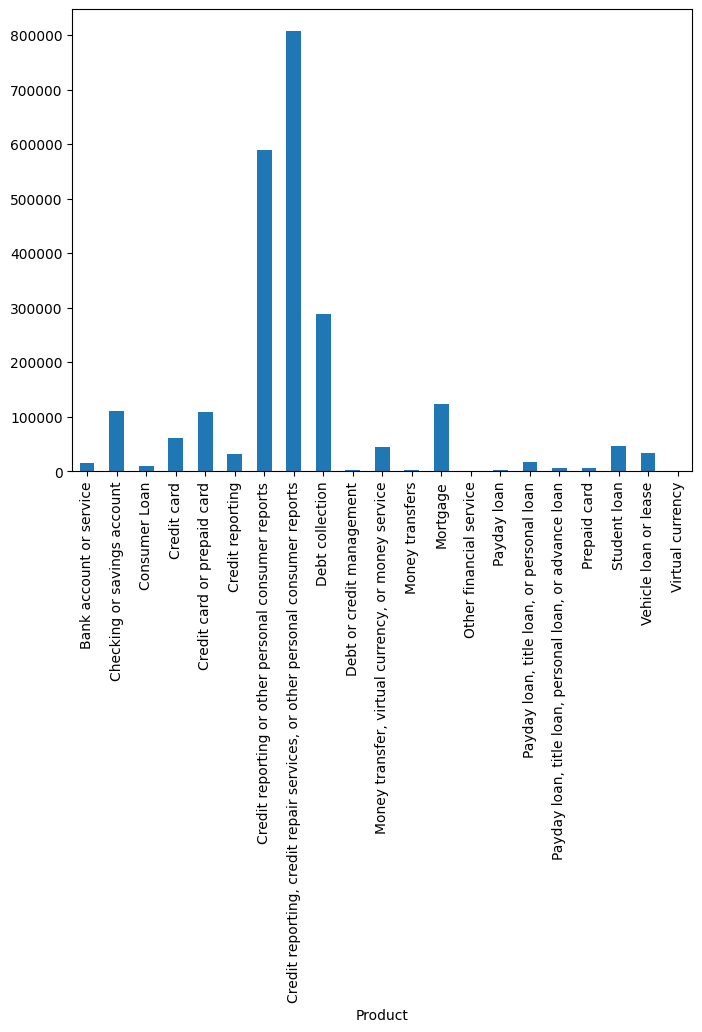

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Consumer_complaint_narrative)
labels = df.category_id
features.shape

(2301581, 2044242)

In [15]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . scottrade
       . citigold
  . Most correlated bigrams:
       . opened citigold
       . citigold checking
# 'Checking or savings account':
  . Most correlated unigrams:
       . funds
       . bank
  . Most correlated bigrams:
       . savings account
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . vehicle
       . car
  . Most correlated bigrams:
       . drive time
       . dealer services
# 'Credit card':
  . Most correlated unigrams:
       . overdue
       . card
  . Most correlated bigrams:
       . bureau start
       . want bureau
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . rewards
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting':
  . Most correlated unigrams:
       . experian
       . equifax
  . Most correlated bigrams:
       . tax lien
       . disputed resolve
# 'Credit reportin

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [17]:
print(clf.predict(count_vect.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

['Debt collection']


In [18]:
print(clf.predict(count_vect.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [19]:
df[df['Consumer_complaint_narrative'] == "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."]

,Product,Consumer_complaint_narrative,category_id
89118,Debt collection,This company refuses to provide me verificatio...,0


In [20]:
df[df['Consumer_complaint_narrative'] == "I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"]

,Product,Consumer_complaint_narrative,category_id
424,Credit reporting,I am disputing the inaccurate information the ...,1


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

In [ ]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from IPython.display import display

for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint_narrative']])
      print('')

In [ ]:
model.fit(features, labels)

In [ ]:
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

In [ ]:
texts = ["I requested a home loan modification through Bank of America. Bank of America never got back to me.",
         "It has been difficult for me to find my past due balance. I missed a regular monthly payment",
         "I can't get the money out of the country.",
         "I have no money to pay my tuition",
         "Coinbase closed my account for no reason and furthermore refused to give me a reason despite dozens of request"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred,
                                    target_names=df['Product'].unique()))